## imports

In [1]:
import pylizard, matplotlib.pyplot as plt, pastas, pandas
%matplotlib inline

## Groundwater monitoring data

Collect monitoring well in well field Nij Beets

In [2]:
p={}
code, filt = '11BP0071', [1, 2, 5, 6, 7]
for f in filt:
    print(code, f)
    pi = pylizard.Peilbuis(code, f)
    p['{}, filter {}, ({}, {})'.format(code, f, pi.okf, pi.bkf)] = pi.head_total(method='fill_no_diver').resample('D').mean()
    

11BP0071 1
11BP0071 2
11BP0071 5
11BP0071 6
11BP0071 7


PLot observed head

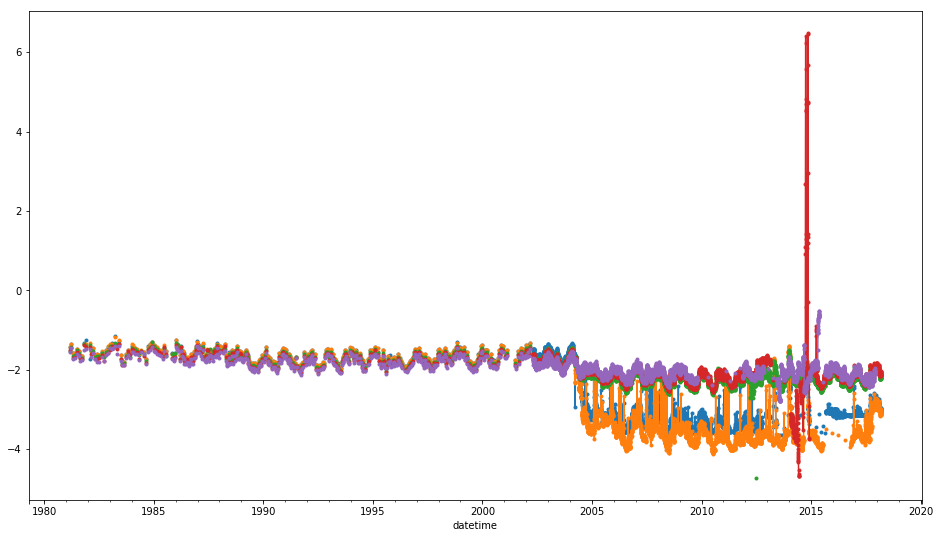

In [3]:
for k, v in p.items():
    v.plot(label=k, marker='.', figsize=[16, 9])

## KNMI and well data

Collect data

In [4]:
knmi_stn = pastas.read.KnmiStation(stns=270, start='1988',  interval='daily')
knmi_stn.download()

rain = knmi_stn.data['RH'].resample('D').sum()
evap = knmi_stn.data['EV24'].resample('D').sum()

well = pandas.read_csv(r'C:\python\hydronotebooks\Lizard\nyb.csv', parse_dates=['date'], index_col='date')['q_m3'].resample('D').sum()

Plot data

(6574, 16071)

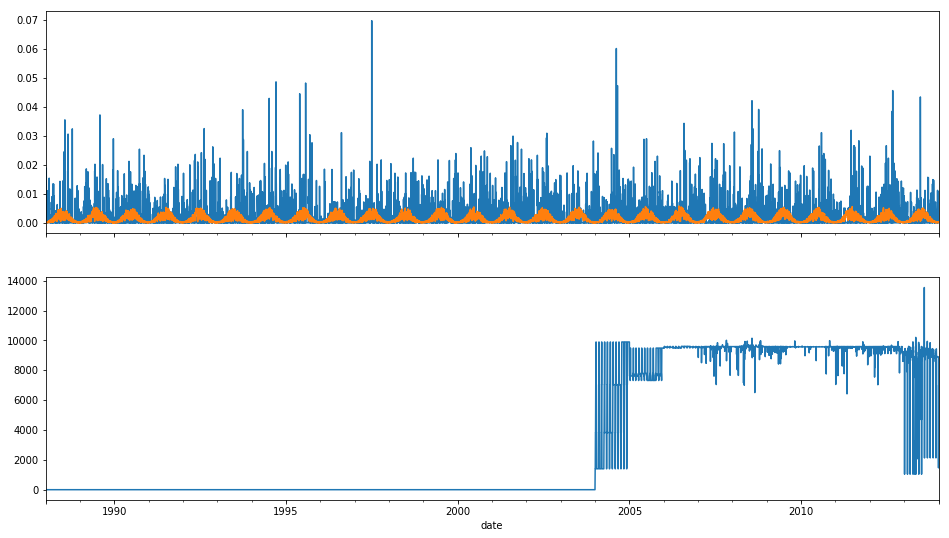

In [5]:
fig, ax = plt.subplots(2, figsize=[16,9], sharex=True)

rain.plot(ax=ax[0])
evap.plot(ax=ax[0])
well.plot(ax=ax[1])
plt.xlim('1988', '2014')

## Timeserie model

Create a Pastas-models

In [6]:
sm_rainevap  = pastas.StressModel2([rain, evap],
                                   pastas.Gamma,
                                   name='rainevap',
                                   settings=('prec', 'evap'))
sm_well = pastas.StressModel(well,
                             pastas.Gamma,
                             name='well',
                             settings='well',
                             up=False)
ml = {}
for k,v in p.items():
    mli = pastas.Model(v)
    mli.add_stressmodel(sm_rainevap)
    mli.add_stressmodel(sm_well)
    mli.solve(tmin='1988', tmax='2014', report=False)
    ml['{}, (evp={}, rmse={})'.format(k, round(mli.stats.evp(), 2), round(mli.stats.rmse(), 2))]=mli

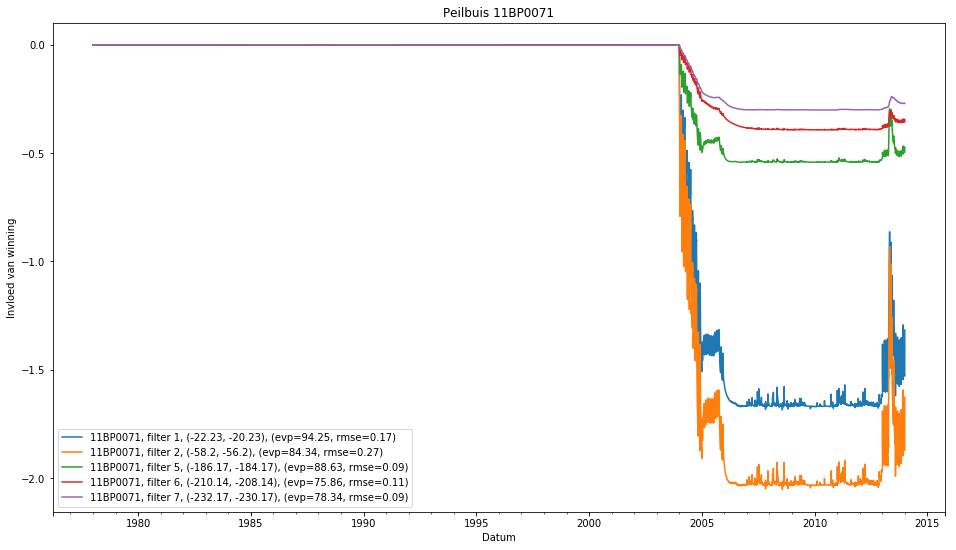

In [7]:
fig, ax = plt.subplots(figsize=[16,9])
for k,v in ml.items():
    v.get_contribution('well').plot(label=k, ax=ax)
plt.title('Peilbuis {}'.format(code))
plt.xlabel('Datum')
plt.ylabel('Invloed van winning')
plt.legend()